## Experiments approximating the posterior with diagonal Gaussians from SGLD samples

We start by building the model and showing the basic inference procedure and calculation of the performance on the MNIST classification and the outlier detection task. Then perform multiple runs of the model with different number of samples in the ensemble to calculate performance statistics.

In [1]:
# Let's first setup the libraries, session and experimental data
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import scipy.stats
import experiment
import inferences
import edward as ed
import tensorflow as tf
import numpy as np
import os

s = experiment.setup()
mnist, notmnist = experiment.get_data()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting notMNIST_data/train-images-idx3-ubyte.gz
Extracting notMNIST_data/train-labels-idx1-ubyte.gz
Extracting notMNIST_data/t10k-images-idx3-ubyte.gz
Extracting notMNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# Builds the model and approximation variables used for the model
y_, model_variables = experiment.get_model_3layer()
approx_variables = experiment.get_gauss_approximation_variables_3layer()

In [3]:
# Performs inference with our custom inference class
inference_dict = {model_variables[key]: val for key, val in approx_variables.iteritems()}
inference = inferences.VariationalGaussSGLD(inference_dict, data={y_: model_variables['y']})
n_iter=1000

trajectory = pd.DataFrame(columns=['step', 'weight'])

inference.initialize(n_iter=n_iter, step_size=0.005, burn_in=0)

tf.global_variables_initializer().run()
for i in range(n_iter):
    batch = mnist.train.next_batch(100)
    info_dict = inference.update({model_variables['x']: batch[0],
                                  model_variables['y']: batch[1]})
    inference.print_progress(info_dict)
    trajectory.loc[i] = [i, inference.empirical_vals[model_variables['W_0']][380, 100].eval()]

inference.finalize()
sigmas = np.concatenate([e.sigma.eval().reshape((-1,)) for e in approx_variables.values()])
print('Statistics of stddev of approximation: mean: {} median: {}'.format(sigmas.mean(), np.median(sigmas)))

1000/1000 [100%] ██████████████████████████████ Elapsed: 76s | Acceptance Rate: 1.000
Statistics of stddev of approximation: mean: 0.000475675711641 median: 0.000395866169129


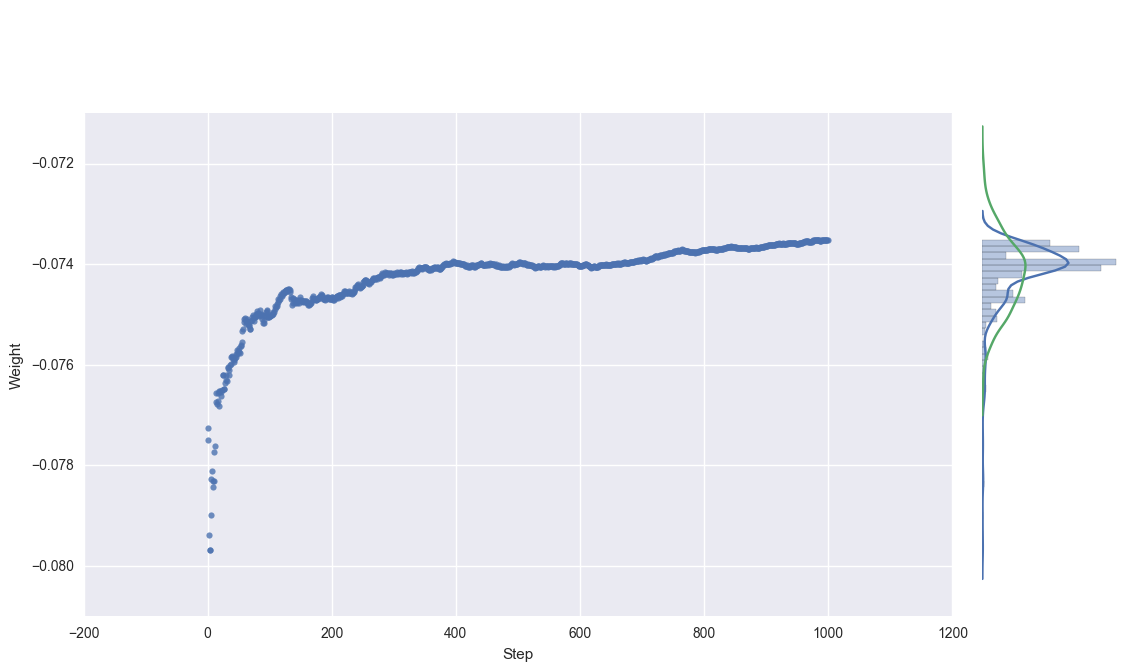

In [4]:
samples = np.random.normal(loc=trajectory['weight'].mean(),
                           scale=trajectory['weight'].std(),
                           size=(len(trajectory), ))

matplotlib.rcParams.update({'font.size': 70})
g = sns.JointGrid(trajectory['step'], trajectory['weight'])
g.plot_joint(lambda x,y: sns.regplot(x, y, fit_reg=False))

g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()

sns.distplot(trajectory['weight'], kde=True, ax=g.ax_marg_y, vertical=True)
sns.distplot(samples, kde=True, hist=False, ax=g.ax_marg_y, vertical=True)

plt.ylabel('Weight')
plt.xlabel('Step')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
#plt.axis([0, 1000,0.0745, 0.0775])
plt.draw()
plt.savefig('trajectory_sgldlr.png', dpi=300)
plt.show()

In [5]:
# Performs inference with our custom inference class
inference_dict = {model_variables[key]: val for key, val in approx_variables.iteritems()}
inference = inferences.VariationalGaussNoisyAdam(inference_dict, data={y_: model_variables['y']})
n_iter=1000

adam_trajectory = pd.DataFrame(columns=['step', 'weight'])

inference.initialize(n_iter=n_iter, learning_rate=0.005, burn_in=0)

tf.global_variables_initializer().run()
for i in range(n_iter):
    batch = mnist.train.next_batch(100)
    info_dict = inference.update({model_variables['x']: batch[0],
                                  model_variables['y']: batch[1]})
    inference.print_progress(info_dict)
    adam_trajectory.loc[i] = [i, inference.empirical_vals[model_variables['W_0']][380, 100].eval()]

inference.finalize()
sigmas = np.concatenate([e.sigma.eval().reshape((-1,)) for e in approx_variables.values()])
print('Statistics of stddev of approximation: mean: {} median: {}'.format(sigmas.mean(), np.median(sigmas)))

1000/1000 [100%] ██████████████████████████████ Elapsed: 191s | Acceptance Rate: 1.000
Statistics of stddev of approximation: mean: 0.0150462724268 median: 0.0125091187656


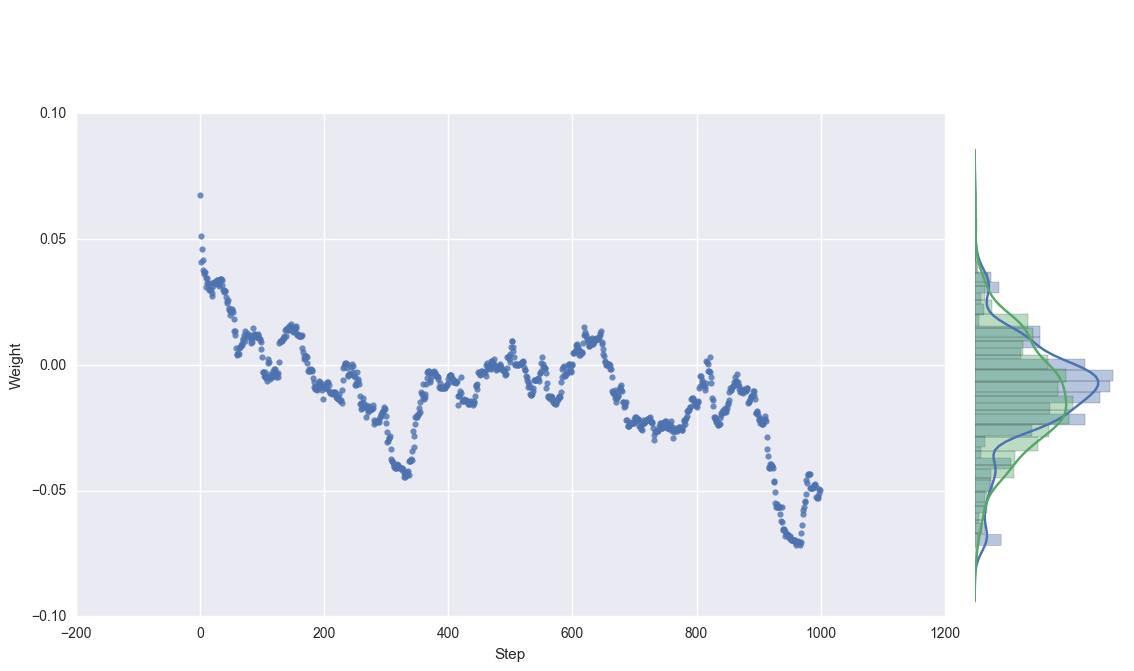

In [6]:
samples = np.random.normal(loc=adam_trajectory['weight'].mean(),
                           scale=adam_trajectory['weight'].std(),
                           size=(len(adam_trajectory), ))

matplotlib.rcParams.update({'font.size': 70})
g = sns.JointGrid(adam_trajectory['step'], adam_trajectory['weight'])
g.plot_joint(lambda x,y: sns.regplot(x, y, fit_reg=False))

g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()

sns.distplot(adam_trajectory['weight'], kde=True, ax=g.ax_marg_y, vertical=True)
sns.distplot(samples, kde=True, ax=g.ax_marg_y, vertical=True)

plt.ylabel('Weight')
plt.xlabel('Step')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
#plt.axis([0, 1000,-0.12, 0.04])
plt.draw()
plt.savefig('trajectory_adam.png', dpi=300)
plt.show()